In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ExponentialLR


import time


/home/torstein/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/tesla_stock.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [3]:
X = df.get('Close').values
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape((-1,1 ))).reshape((-1))

split_index = 1400
print(X.shape)
X_train, X_test = X[:split_index], X[split_index:] #train_test_split(X, test_size=0.1, shuffle=False)
timesteps_count = 30

def get_train_test():
    x_train, y_train, x_test, y_test = [], [], [], []

    i = 0
    while i+timesteps_count<len(X_train):
        x_train.append(X_train[i:i+timesteps_count])
        y_train.append(X_train[i+timesteps_count])
        i+=1

    i=0
    while i+timesteps_count<len(X_test):
        x_test.append(X_test[i:i+timesteps_count])
        y_test.append(X_test[i+timesteps_count])
        i+=1
        
    x_train, y_train = torch.tensor(np.array(x_train), dtype=torch.float), torch.tensor(np.array(y_train), dtype=torch.float)
    x_test, y_test = torch.tensor(np.array(x_test), dtype=torch.float), torch.tensor(np.array(y_test), dtype=torch.float)
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = get_train_test()
print(x_train.shape, y_train.shape)

(1692,)
torch.Size([1370, 30]) torch.Size([1370])


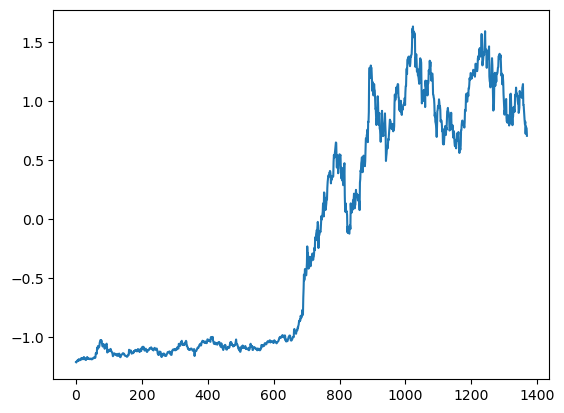

In [4]:
plt.plot(y_train)

## Develop an LSTM network

In [5]:
MAX_TIME = 30

In [6]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):

        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=2)

        self.linear1 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
        # if len(x.shape)==2:
        #     out = x.view((-1, 1, self.input_dim))
        out,_ = self.lstm1(out)
        out = self.linear1(out)
        #out = self.linear2(out)
        out = out.view((-1, ))
        return out


class LinearPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):

        super(LinearPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.linear1 = nn.Linear(input_dim, 1)
        #self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
        # if len(x.shape)==2:
        #     out = x.view((-1, 1, self.input_dim))
        out = self.linear1(out)
        #out = nn.ReLU()(out)
        #out = self.linear2(out)
        out = out.view((-1, ))
        return out




 97%|█████████▋| 29/30 [00:29<00:01,  1.03s/it]


Text(0.5, 1.0, 'Train')

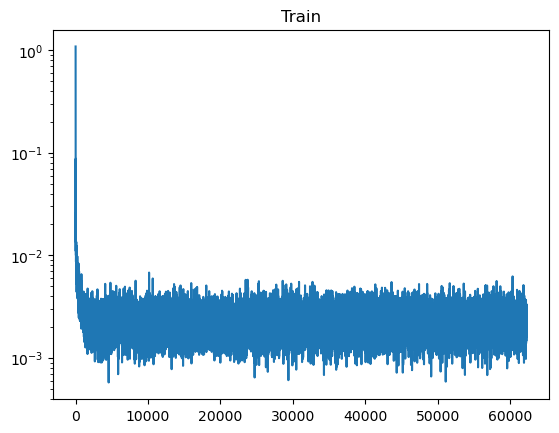

In [7]:
#model = LSTMPredictor(x_train.shape[1], hidden_dim = 10)
model = LinearPredictor(x_train.shape[1], hidden_dim = 60)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
EPOCHS = 10
BATCH_SIZE = 256
N = x_train.shape[0]
losses_adam = []
t0 = time.time()
t1 = time.time()
with tqdm(total=MAX_TIME) as pbar:
    while time.time()<t0+MAX_TIME:
        if time.time()>t1+1:
            t1 = time.time()
            pbar.update()
        indices = np.arange(len(x_train))
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]
        #print(indices.shape)
        for i in range(N//BATCH_SIZE+1):
            model.zero_grad()
            batch_x = x_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            batch_y = y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()

            losses_adam.append(loss.detach().numpy())
        scheduler.step

 
plt.semilogy(losses_adam)
plt.title("Train")

tensor(23.8490, dtype=torch.float64)


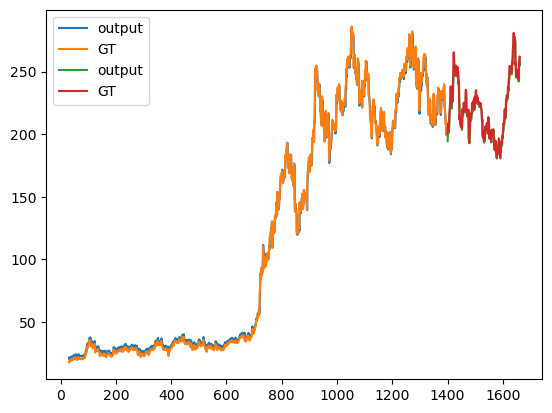

In [8]:
def test(model):
    with torch.no_grad():
        
        output = model(x_test)
        unscaled_output = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_test = scaler.inverse_transform(y_test.reshape((-1, 1))).reshape((-1,))

        output = model(x_train)

        unscaled_output_train = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_train = scaler.inverse_transform(y_train.reshape((-1, 1))).reshape((-1,))


        loss = loss_fn(torch.tensor(unscaled_output),torch.tensor(unscaled_y_test ))
        plt.figure()
        #print(unscaled_output_train.shape)
        plt.plot(np.arange(timesteps_count, split_index), unscaled_output_train, label="output")
        plt.plot(np.arange(timesteps_count, split_index), unscaled_y_train, label="GT")
        
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_output, label="output")
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_y_test, label="GT")
        plt.legend()
        print(loss)
x_train, y_train, x_test, y_test = get_train_test()

test(model)

## Predicting with moving average

In [9]:
window_size = 50
df["MA"] = df["Close"].rolling(window_size).mean()

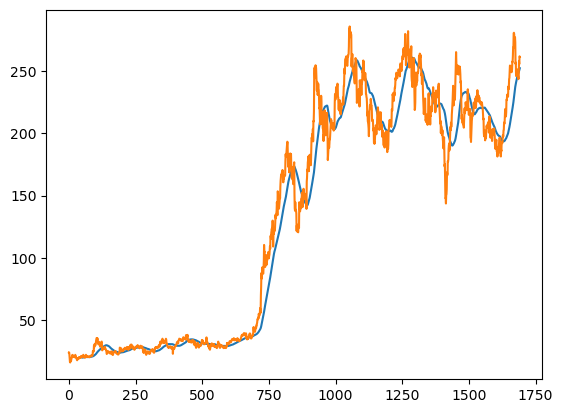

In [10]:
plt.plot(df["MA"])
plt.plot(df["Close"])

## Prediction with exponential average

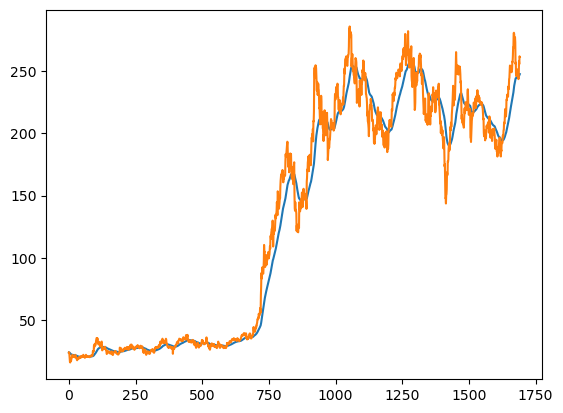

In [11]:
df["EA"] = df["Close"].ewm(span=window_size, adjust=False).mean()
plt.plot(df["EA"])
plt.plot(df["Close"])


In [22]:
%load_ext autoreload
%autoreload 2

from functions.PyTorchGN import NN_GN
from algorithms.algo2 import optimize

x_train, y_train, x_test, y_test = get_train_test()

y_train = y_train.reshape((-1, 1)).detach().numpy()
x_train = x_train.detach().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1370, 30) (1370, 1) (14911,)
Parameter count 14911


  0%|          | 1/300 [00:01<05:59,  1.20s/it]

0
block creation 0.9234721660614014
step calculation 0.05123138427734375
backtrack 0.17619538307189941


  1%|          | 2/300 [00:02<05:50,  1.18s/it]

0
block creation 0.8008992671966553
step calculation 0.055877685546875
backtrack 0.23673439025878906
Train error:  1.0180406188964843 lambd:  0.25
Epoch time:  1.1554741859436035


  1%|          | 3/300 [00:03<05:28,  1.11s/it]

0
block creation 0.7570297718048096
step calculation 0.04636883735656738
backtrack 0.16939568519592285


  1%|▏         | 4/300 [00:04<05:17,  1.07s/it]

0
block creation 0.7579216957092285
step calculation 0.04357743263244629
backtrack 0.1682140827178955


  2%|▏         | 5/300 [00:05<05:09,  1.05s/it]

0
block creation 0.737525224685669
step calculation 0.04834485054016113
backtrack 0.16803812980651855
Train error:  1.0049987030029297 lambd:  0.03125
Epoch time:  1.0051922798156738


  2%|▏         | 6/300 [00:06<05:17,  1.08s/it]

0
block creation 0.8522911071777344
step calculation 0.04542732238769531
backtrack 0.18578505516052246


  2%|▏         | 7/300 [00:07<05:20,  1.09s/it]

0
block creation 0.7918212413787842
step calculation 0.05106782913208008
backtrack 0.21061348915100098


  3%|▎         | 8/300 [00:08<05:21,  1.10s/it]

0
block creation 0.8154613971710205
step calculation 0.04997658729553223
backtrack 0.19128990173339844
Train error:  0.9804315185546875 lambd:  0.00390625
Epoch time:  1.117882251739502


  3%|▎         | 9/300 [00:09<05:15,  1.08s/it]

0
block creation 0.759178876876831
step calculation 0.04464459419250488
backtrack 0.18781304359436035


  3%|▎         | 10/300 [00:10<05:18,  1.10s/it]

0
block creation 0.8633363246917725
step calculation 0.044938087463378906
backtrack 0.1696610450744629


  4%|▎         | 11/300 [00:12<05:20,  1.11s/it]

0
block creation 0.8179397583007812
step calculation 0.056215763092041016
backtrack 0.20000362396240234
Train error:  0.9947660827636718 lambd:  0.00048828125
Epoch time:  1.1340458393096924


  4%|▍         | 12/300 [00:13<05:20,  1.11s/it]

0
block creation 0.8245429992675781
step calculation 0.0438990592956543
backtrack 0.18650245666503906


  4%|▍         | 13/300 [00:14<05:21,  1.12s/it]

0
block creation 0.8576047420501709
step calculation 0.059767723083496094
backtrack 0.16588258743286133


  5%|▍         | 14/300 [00:15<05:19,  1.12s/it]

0
block creation 0.8449344635009766
step calculation 0.047554731369018555
backtrack 0.17008733749389648
Train error:  0.9693244171142578 lambd:  6.103515625e-05
Epoch time:  1.1142632961273193


  5%|▌         | 15/300 [00:16<05:13,  1.10s/it]

0
block creation 0.7965209484100342
step calculation 0.04421854019165039
backtrack 0.17038416862487793


  5%|▌         | 16/300 [00:17<05:09,  1.09s/it]

0
block creation 0.791109561920166
step calculation 0.05044221878051758
backtrack 0.1700448989868164


  6%|▌         | 17/300 [00:18<05:04,  1.08s/it]

0
block creation 0.7903347015380859
step calculation 0.04323410987854004
backtrack 0.16636204719543457
Train error:  1.0222053527832031 lambd:  7.62939453125e-06
Epoch time:  1.048518419265747


  6%|▌         | 18/300 [00:19<05:02,  1.07s/it]

0
block creation 0.7976086139678955
step calculation 0.05026412010192871
backtrack 0.16829609870910645


  6%|▋         | 19/300 [00:20<05:00,  1.07s/it]

0
block creation 0.7954733371734619
step calculation 0.04806876182556152
backtrack 0.16940903663635254


  7%|▋         | 20/300 [00:21<04:59,  1.07s/it]

0
block creation 0.7913541793823242
step calculation 0.04762434959411621
backtrack 0.17090535163879395
Train error:  0.9773706817626953 lambd:  9.5367431640625e-07
Epoch time:  1.0652577877044678


  7%|▋         | 21/300 [00:22<04:59,  1.07s/it]

0
block creation 0.8161683082580566
step calculation 0.04425787925720215
backtrack 0.16578316688537598


  7%|▋         | 22/300 [00:24<05:01,  1.08s/it]

0
block creation 0.8151912689208984
step calculation 0.04833054542541504
backtrack 0.1894378662109375


  8%|▊         | 23/300 [00:25<04:57,  1.07s/it]

0
block creation 0.7849071025848389
step calculation 0.04554009437561035
backtrack 0.16803646087646484
Train error:  0.9712385559082031 lambd:  1.1920928955078125e-07
Epoch time:  1.047314167022705


  8%|▊         | 24/300 [00:26<04:54,  1.07s/it]

0
block creation 0.7948107719421387
step calculation 0.04501771926879883
backtrack 0.16626381874084473


  8%|▊         | 25/300 [00:27<04:52,  1.06s/it]

0
block creation 0.791867733001709
step calculation 0.04427647590637207
backtrack 0.1686229705810547


  9%|▊         | 26/300 [00:28<04:50,  1.06s/it]

0
block creation 0.7888481616973877
step calculation 0.04805111885070801
backtrack 0.16742253303527832
Train error:  1.0065828704833983 lambd:  5.960464477539063e-08
Epoch time:  1.0546000003814697


  9%|▉         | 27/300 [00:29<04:49,  1.06s/it]

0
block creation 0.7839932441711426
step calculation 0.04221391677856445
backtrack 0.17827320098876953


  9%|▉         | 28/300 [00:30<04:55,  1.09s/it]

0
block creation 0.847510814666748
step calculation 0.03951859474182129
backtrack 0.16897821426391602
timeout
0.16499135


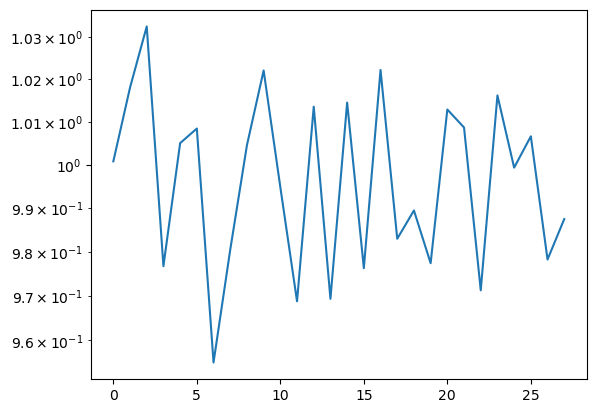

In [23]:
input_dim, hidden_dim = x_train.shape[1], 30
model = LSTMPredictor(input_dim, hidden_dim)

input_dim, hidden_dim = x_train.shape[1], 30

#model = LinearPredictor(input_dim, hidden_dim)
nn_gn = NN_GN(model, is_linear=False)
X0 = np.zeros_like(nn_gn.get_X())


print(x_train.shape, y_train.shape, X0.shape)
## Do Gauss Newton

X_est,losses_gn, _ = optimize(nn_gn, X0, x_train, y_train, steps=300,batch_size=400 ,
max_time=MAX_TIME,backtrack=True,optimization_method="Random columns")

print(np.linalg.norm(X_est-X0))
plt.semilogy(losses_gn)

tensor(10443.4707, dtype=torch.float64)


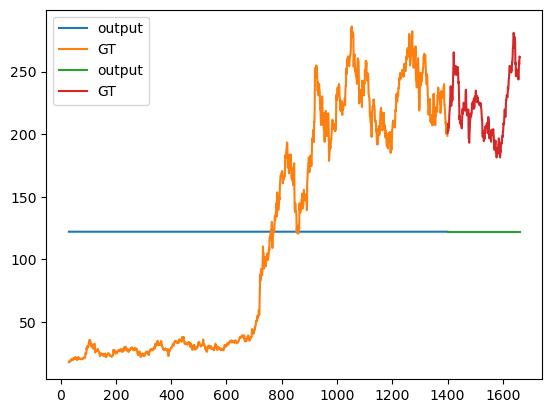

In [21]:
x_train, y_train, x_test, y_test = get_train_test()


test(model)

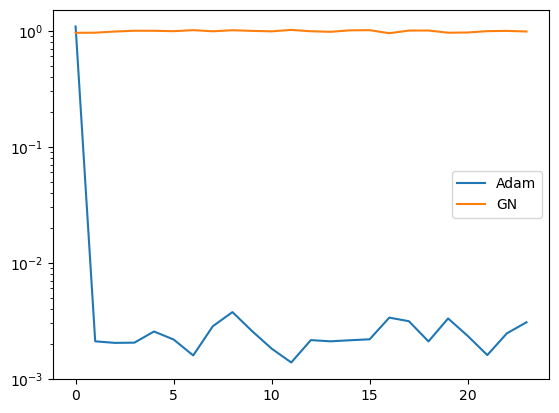

In [15]:
idx = np.round(np.linspace(0, len(losses_adam) - 1, len(losses_gn))).astype(int)
plt.semilogy(np.array(losses_adam)[idx], label="Adam")
plt.semilogy(losses_gn, label="GN")
plt.legend()